# DAAI Project - Final Version

## 00 - Preliminary Steps

### Install the Requiered Packages



In [ ]:
!pip install -r requirements.txt
!pip install -r requirements_2.txt
!pip install openai-clip   # This was needed because I could not use "!git" in colab connected to a local runtime

ERROR: Invalid requirement: '#': Expected package name at the start of dependency specifier
    #
    ^


### Import the Required Libraries

In [ ]:
import torch
import os
from args import parse_arguments
from datasets.common import get_dataloader, maybe_dictionarize
from datasets.registry import get_dataset
from modeling import ImageClassifier, ImageEncoder
from heads import get_classification_head
from task_vectors_modified import NonLinearTaskVector
from utils import train_diag_fim_logtr
from finetune_fcn_V2 import finetune
import sys
from tqdm import tqdm
from torch import nn
from torch import optim
from torch.backends import cudnn
import os
from pathlib import Path
import pandas as pd
import numpy as np
import warnings
import copy
from glob import glob
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

### Set Hyperparameters and Files Locations

In [ ]:
# Decide hyperparameters' values
device = "cuda" if torch.cuda.is_available() else "cpu"
dataset_name_original = "DTD"    # DTD, EuroSAT, GTSRB, MNIST, RESISC45, SVHN
data_location = "data"
models_location = "models"
results_location = "results"
batch_size_original = 32
lr_original = 1e-4
weight_decay_original = 0
num_workers_original = 0
# epochs = 1
model_save = "preserve"   # preserve or overwrite the file models that are already present in the "models_location" folder
model_version_original = "V1"
datasets_name = ["DTD", "EuroSAT", "GTSRB", "MNIST", "RESISC45", "SVHN"]

# Set the command-line arguments
sys.argv = [
    "script_name.py",  # Placeholder script name
    "--data-location", data_location,
    "--model", "ViT-B-32",
    "--save", models_location
]
# Parse the arguments
args = parse_arguments()

# Initial setting of the hyperparameters
dataset_name = dataset_name_original
batch_size = batch_size_original
lr = lr_original
weight_decay = weight_decay_original
num_workers = num_workers_original

### Additional Settings

In [ ]:
# Setup optimised alghoritm for the hardware when handling models
cudnn.benchmark = True
# Do not display warning when creating an instance of the model
warnings.filterwarnings("ignore")

### Preliminary Functions

In [ ]:
# Define a function that iterates of the state dictionaries (parameters) of the pretrained model and the finetuned model chosen calculating the respective task vector as the difference between the respective entries of the two state dictionaries
def compute_task_vector(dataset_name, models_location, model_version):

  # Define the paths where the pretrained model's and of the finetuned model's state dictionaries have been stored
  pt_path = models_location + "\\encoder_PreTrained.pt"
  ft_path = f"{models_location}/{model_version}_encoder_SingleTask_{dataset_name}.pt"

  # Load the state dictionaries without the gradients
  with torch.inference_mode():
    pt_state_dict = torch.load(pt_path)
    ft_state_dict = torch.load(ft_path)

    # Calculate the task vector as the difference of state dictiories entries for the same model's layer
    task_vector = {}
    for key in pt_state_dict:
      task_vector[key] = ft_state_dict[key] - pt_state_dict[key]

  # The task vector is the output of this function
  return task_vector

# Define a function that given a vector returns its unit vector
def normalize_vector(vector):
  norm = np.linalg.norm(vector)
  if norm == 0:
    return vector
  return vector/norm

In [ ]:
# Create a new instance of the model, this model will have the state dictionary of the pretrained model if no state_dict is provided, otherwise the state dict will bw overwritten with the one provided
def create_model(args = args,
                 device = device,
                 state_dict = None):

  # Now you can use the args object with get_classification_head
  head = get_classification_head(args, dataset_name)
  # Instantiate a full model architecture
  encoder = ImageEncoder(args) # Pre-trained CLIP ViT backbone
  model = ImageClassifier(encoder, head).to(device) # Build full model

  # If the state dictionary is provided, load it in the model's image encoder
  if state_dict:
    model.image_encoder.load_state_dict(state_dict)

  # Outputs the model
  return model

In [ ]:
# Calculates the model performance, as default it will only calculate the validation accuracy, but it can also calculate train and test accuracies, along with the fisher matrix trace logarithm, and it also enables to save the results in the path specified in "save_results"
def model_performance(model, dataset_name, addValidation=True, addTest=False, addTrain=False, addFisher=False, save_results=None, show_tqdm=True, samples_nr=200, results_location="results"):

  # Set-up benchmark mode make training faster
  cudnn.benchmark = True
  # Disable warnings to reduce clutter in the output
  warnings.filterwarnings("ignore")

  # Create the folders where to save the results if not present
  os.makedirs(f"{results_location}/Alpha Optim", exist_ok=True)
  os.makedirs(f"{results_location}/Final Results/Multitask", exist_ok=True)
  os.makedirs(f"{results_location}/Final Results/Pretraned and Singletask", exist_ok=True)
  os.makedirs(f"{results_location}/Final Results/Singletask Scaled", exist_ok=True)


  # Initialise the dictionary where to store the results
  results = {}

  if addTest:
    # Obtain the Test split
    test_dataset = get_dataset(dataset_name, preprocess=model.val_preprocess, location=args.data_location, batch_size=batch_size, num_workers=num_workers)
    test_loader = get_dataloader(test_dataset, is_train=False, args=args)
    # Calculate test accuracy
    acc = 0
    model.eval()
    with torch.inference_mode():
      for batch in tqdm(test_loader, desc="Test Accuracy Calculation") if show_tqdm else test_loader:
        data = maybe_dictionarize(batch)
        x, y = data["images"], data["labels"]
        x, y = x.to(device), y.to(device)
        logits = model(x)
        labels = logits.argmax(dim=1)
        acc += (y == labels).sum().item()/len(y)
      acc /= len(test_loader)
      acc *= 100
      results["Test Accuracy [%]"] = acc

  if addValidation:
    # Obtain the Validation split
    val_dataset = get_dataset(
    dataset_name+"Val", preprocess=model.val_preprocess,
    location=args.data_location, batch_size=batch_size, num_workers=num_workers)
    val_loader = get_dataloader(val_dataset, is_train=False, args=args)

    # Calculate validation accuracy
    acc_val = 0
    model.eval()
    with torch.inference_mode():
      for batch in tqdm(val_loader, desc="Validation Accuracy Calculation") if show_tqdm else val_loader:
        data = maybe_dictionarize(batch)
        x, y = data["images"], data["labels"]
        x, y = x.to(device), y.to(device)
        logits = model(x)
        labels = logits.argmax(dim=1)
        acc_val += (y == labels).sum().item()/len(y)
      acc_val /= len(val_loader)
      acc_val *= 100
      results["Validation Accuracy [%]"] = acc_val

  if addTrain:
    # Obtain the Train split
    train_dataset = get_dataset(
    dataset_name, preprocess=model.train_preprocess,
    location=args.data_location, batch_size=batch_size, num_workers=num_workers)
    train_loader = get_dataloader(train_dataset, is_train=True, args=args)

    # Calculate train accuracy
    acc_train = 0
    model.eval()
    with torch.inference_mode():
      for batch in tqdm(train_loader, desc="Test Accuracy Calculation") if show_tqdm else train_loader:
        data = maybe_dictionarize(batch)
        x, y = data["images"], data["labels"]
        x, y = x.to(device), y.to(device)
        logits = model(x)
        labels = logits.argmax(dim=1)
        acc_train += (y == labels).sum().item()/len(y)
      acc_train /= len(train_loader)
      acc_train *= 100
      results["Train Accuracy [%]"] = acc_train


  if addFisher:
    print("\nFisher matrix logarithm trace Calcuation ...")
    # Calculate Fisher matrix logarithm trace
    logdet_hF = train_diag_fim_logtr(args, model, dataset_name, samples_nr)
    results["log(Tr(F))"] = logdet_hF

  if save_results:
    if os.path.exists(save_results):
      print(f"Results cannot be saved, because '{save_results}' already exists")
    else:
      with open(save_results, 'w') as file:
        for key, value in results.items():
          file.write(f"{key}: {value}\n")
      print(f"\nResults correctly saved in '{save_results}'")


  return results

## 01 - Finetuned Models

In this section different instances of the ViT-B/32 are created and trained using multiple combinations of hyperparameters.

### Models Versions Table

In [ ]:
# Define the data that describe the hyperparametes in a dictionary
data = {
  "Train/Test Version": ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13"],
  "Batch Size": [32, 8, 16, 64, 128, 32, 32, 32, 32, 32, 32, 32, 32],
  "Learning Rate": [1e-04, 1e-04, 1e-04, 1e-04, 1e-04, 5e-04, 5e-05, 1e-05, 1e-04, 1e-04, 1e-04, 1e-04, 1e-04],
  "Weight Decay": [0, 0, 0, 0, 0, 0, 0, 0, 0.1, 0.01, 0.001, 0, 0],
  "Stopping Criteria": ["Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Last Iteration", "Max log(tr(F))", "Max Val Accuracy"]
  }

# Create a dataframe with the dictionary above to easily visualise and iterate the different hyperparameters sets
df = pd.DataFrame(data)
df

,Train/Test Version,Batch Size,Learning Rate,Weight Decay,Stopping Criteria
0,V1,32,0.00010,0.000,Last Iteration
1,V2,8,0.00010,0.000,Last Iteration
2,V3,16,0.00010,0.000,Last Iteration
3,V4,64,0.00010,0.000,Last Iteration
4,V5,128,0.00010,0.000,Last Iteration
5,V6,32,0.00050,0.000,Last Iteration
6,V7,32,0.00005,0.000,Last Iteration
7,V8,32,0.00001,0.000,Last Iteration
8,V9,32,0.00010,0.100,Last Iteration
9,V10,32,0.00010,0.010,Last Iteration


### Train the Models

In [ ]:
# Iterate over the hyperparameters
for _, row in tqdm(df.iterrows(), total=len(df), desc="\n\n\nIterating Model Versions\n\n\n"):

  # Assign the hyperparameters to variables to feed to the function that trains the models
  model_version = row['Train/Test Version']
  batch_size = row["Batch Size"]
  lr = row['Learning Rate']
  weight_decay = row['Weight Decay']
  stopping_criteria_name = row["Stopping Criteria"]
  if stopping_criteria_name == "Max log(tr(F))":
    stopping_criteria = "max_logdet_hF"
  elif stopping_criteria_name == "Max Val Accuracy":
    stopping_criteria = "max_val_acc"
  else:
    stopping_criteria = "last_iter"

  # Display the model version to be trained and its hyperparameters
  print(f"\nCreating the Single-Task models {model_version}")
  print(f"Batch Size = {batch_size} \nLearning Rate = {lr} \nWeight Decay = {weight_decay} \nStopping Criteria = {stopping_criteria} \n\n\n")

  # Train the (singletask) finetuned model with the hyperparameters assigned above
  finetune(data_location=data_location,
           model_version=model_version,
           batch_size=batch_size,
           lr=lr,
           weight_decay=weight_decay,
           stopping_criteria=stopping_criteria,
           model_save=model_save,
           num_workers=num_workers)

# Clear GPU vRam
torch.cuda.empty_cache()

## 02 - Pretrained and Singletask Model Testing

### Test and Save the Singletask Model

In [ ]:
# Set hyperparameters to the values decided by the user
batch_size = batch_size_original
num_workers = num_workers_original

# Define model versions to iterate
model_versions = ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13"]

# Define the path where the pretrained model state dictionary has been saved
pt_path = f"{models_location}/encoder_PreTrained.pt"

# Iterate through the model versions
for model_version in tqdm(model_versions, desc="Iterating Model Versions"):

  # Iterate thourgh the datasets
  for dataset_name in tqdm(datasets_name, desc="Iterating Datasets"):
    print(f"\nTesting model {model_version} with dataset {dataset_name}")

    # Define where to save the results and the name of the result file
    save_path = f"{results_location}/Final Results/Pretraned and Singletask/{model_version}_{dataset_name}.txt"

    # If the result file does alerady exist the testing is not run and a message is displayed instead
    if os.path.exists(save_path):
        print(f"Test not run, because '{save_path}' already exists.")
    else:

      # Create a model using the state dictionary defined in "path"
      path = f"{models_location}/{model_version}_encoder_SingleTask_{dataset_name}.pt"
      state_dict = torch.load(path)
      model = create_model(state_dict=state_dict)

      # Calculate the training accuracy, testing accuracy, and Fisher matrix trace logaritm, save the results in save_path
      acc = model_performance(model=model, dataset_name=dataset_name, addValidation=False, addTrain=True, addTest=True, addFisher=True, show_tqdm=False, save_results=save_path)

Iterating Datasets: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]



Testing model V1 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_DTD.txt' already exists.

Testing model V1 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_EuroSAT.txt' already exists.

Testing model V1 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_GTSRB.txt' already exists.

Testing model V1 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_MNIST.txt' already exists.

Testing model V1 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_RESISC45.txt' already exists.

Testing model V1 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V1_SVHN.txt' already exists.



Iterating Datasets: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]



Testing model V2 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_DTD.txt' already exists.

Testing model V2 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_EuroSAT.txt' already exists.

Testing model V2 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_GTSRB.txt' already exists.

Testing model V2 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_MNIST.txt' already exists.

Testing model V2 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_RESISC45.txt' already exists.

Testing model V2 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V2_SVHN.txt' already exists.



Iterating Datasets: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]



Testing model V3 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_DTD.txt' already exists.

Testing model V3 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_EuroSAT.txt' already exists.

Testing model V3 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_GTSRB.txt' already exists.

Testing model V3 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_MNIST.txt' already exists.

Testing model V3 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_RESISC45.txt' already exists.

Testing model V3 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V3_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5949.37it/s]



Testing model V4 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_DTD.txt' already exists.

Testing model V4 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_EuroSAT.txt' already exists.

Testing model V4 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_GTSRB.txt' already exists.

Testing model V4 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_MNIST.txt' already exists.

Testing model V4 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_RESISC45.txt' already exists.

Testing model V4 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V4_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5953.59it/s]



Testing model V5 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_DTD.txt' already exists.

Testing model V5 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_EuroSAT.txt' already exists.

Testing model V5 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_GTSRB.txt' already exists.

Testing model V5 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_MNIST.txt' already exists.

Testing model V5 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_RESISC45.txt' already exists.

Testing model V5 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V5_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5960.64it/s]



Testing model V6 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_DTD.txt' already exists.

Testing model V6 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_EuroSAT.txt' already exists.

Testing model V6 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_GTSRB.txt' already exists.

Testing model V6 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_MNIST.txt' already exists.

Testing model V6 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_RESISC45.txt' already exists.

Testing model V6 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V6_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5946.56it/s]



Testing model V7 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_DTD.txt' already exists.

Testing model V7 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_EuroSAT.txt' already exists.

Testing model V7 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_GTSRB.txt' already exists.

Testing model V7 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_MNIST.txt' already exists.

Testing model V7 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_RESISC45.txt' already exists.

Testing model V7 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V7_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5481.56it/s]



Testing model V8 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_DTD.txt' already exists.

Testing model V8 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_EuroSAT.txt' already exists.

Testing model V8 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_GTSRB.txt' already exists.

Testing model V8 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_MNIST.txt' already exists.

Testing model V8 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_RESISC45.txt' already exists.

Testing model V8 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V8_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 4958.78it/s]



Testing model V9 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_DTD.txt' already exists.

Testing model V9 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_EuroSAT.txt' already exists.

Testing model V9 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_GTSRB.txt' already exists.

Testing model V9 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_MNIST.txt' already exists.

Testing model V9 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_RESISC45.txt' already exists.

Testing model V9 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V9_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5971.96it/s]



Testing model V10 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_DTD.txt' already exists.

Testing model V10 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_EuroSAT.txt' already exists.

Testing model V10 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_GTSRB.txt' already exists.

Testing model V10 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_MNIST.txt' already exists.

Testing model V10 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_RESISC45.txt' already exists.

Testing model V10 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V10_SVHN.txt' already exists.



Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5977.63it/s]



Testing model V11 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_DTD.txt' already exists.

Testing model V11 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_EuroSAT.txt' already exists.

Testing model V11 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_GTSRB.txt' already exists.

Testing model V11 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_MNIST.txt' already exists.

Testing model V11 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_RESISC45.txt' already exists.

Testing model V11 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V11_SVHN.txt' already exists.



Iterating Datasets: 100%|████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]



Testing model V12 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_DTD.txt' already exists.

Testing model V12 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_EuroSAT.txt' already exists.

Testing model V12 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_GTSRB.txt' already exists.

Testing model V12 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_MNIST.txt' already exists.

Testing model V12 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_RESISC45.txt' already exists.

Testing model V12 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V12_SVHN.txt' already exists.



Iterating Model Versions: 100%|███████████████████████████████████████████████████████| 13/13 [00:00<00:00, 318.18it/s]


Testing model V13 with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_DTD.txt' already exists.

Testing model V13 with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_EuroSAT.txt' already exists.

Testing model V13 with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_GTSRB.txt' already exists.

Testing model V13 with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_MNIST.txt' already exists.

Testing model V13 with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_RESISC45.txt' already exists.

Testing model V13 with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/V13_SVHN.txt' already exists.


### Retrieve the Early Stopping Statistics

In [ ]:
# Set hyperparameters to the values decided by the user
batch_size = batch_size_original
num_workers = num_workers_original

# Define the dataset to iterate and for how many epochs they have been iterated during training
datasets_name = ["DTD", "EuroSAT", "GTSRB", "MNIST", "RESISC45", "SVHN"]
datasets_epochs = [76, 12, 11, 5, 15, 4]

# Initialise the "results" dictionary
results = {}

# Iterate through the datasets
for dataset_idx, dataset_name in tqdm(enumerate(datasets_name), total=len(datasets_name), desc="Iterating Datasets"):

  # Initialise a tuple in the results dictionary for each dataset
  results[dataset_name] = []

  # Define the number of epochs to iterate for the current dataset
  epochs = datasets_epochs[dataset_idx]

  # Display for which dataset the model is being tested
  print(f"\nTesting dataset {dataset_name}, for {epochs} epochs")

  # Iterate through the epochs
  for epoch in tqdm(range(epochs), desc="Iterating Epochs"):
  print("\n")

  # Create a model with the state dictionary used during training for the current epoch
  path = f"{results_location}/max_logdet_hF/V12/{dataset_name}/epoch_{epoch+1}"
  state_dict = torch.load(path)
  model = create_model(state_dict=state_dict)

  # Calculate the validation accuracy for the current dataset and epoch and add i to the results dictionary
  result = model_performance(model=model, dataset_name=dataset_name, showTest=False, addFisher=True)
  results[dataset_name].append(result['log(Tr(F))'])

  # Clear cache
  torch.cuda.empty_cache()

print("\n\nOperation Completed!")

# Display results
results

### Test and Save the Pretrained Model

In [ ]:
# Set hyperparameters to the values decided by the user
batch_size = batch_size_original
num_workers = num_workers_original

# Define the dataset to iterate
datasets_name = ["DTD", "EuroSAT", "GTSRB", "MNIST", "RESISC45", "SVHN"]

# Iterate through the datasets
for dataset_name in tqdm(datasets_name, desc="Iterating Datasets"):
  print(f"\nTesting the pretrained model with dataset {dataset_name}")

  # Define where to save the results and the name of the result file
  save_path = f"{results_location}/Final Results/Pretraned and Singletask/pretrained_{dataset_name}.txt"

  # If the result file does alerady exist the testing is not run and a message is displayed instead
  if os.path.exists(save_path):
      print(f"Test not run, because '{save_path}' already exists.")
  else:

    # Create the preterained model
    model = create_model()

    # Calculate train accuracy, test accuracy and Fisher matrix trace logarithm, and save the results
    acc = model_performance(model=model, dataset_name=dataset_name, addValidation=False, addTrain=True, addTest=True, addFisher=True, show_tqdm=False, save_results=save_path)

Iterating Datasets: 100%|██████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5976.21it/s]


Testing the pretrained model with dataset DTD
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_DTD.txt' already exists.

Testing the pretrained model with dataset EuroSAT
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_EuroSAT.txt' already exists.

Testing the pretrained model with dataset GTSRB
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_GTSRB.txt' already exists.

Testing the pretrained model with dataset MNIST
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_MNIST.txt' already exists.

Testing the pretrained model with dataset RESISC45
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_RESISC45.txt' already exists.

Testing the pretrained model with dataset SVHN
Test not run, because 'results/Final Results/Pretraned and Singletask/pretrained_SVHN.txt' already exists.


## 03 - Task Vectors - Cosine Similarity

In this section the relative directions of the normalised task vectors are analysed and displayed.

### Confusion Matrix Within Task Vectors

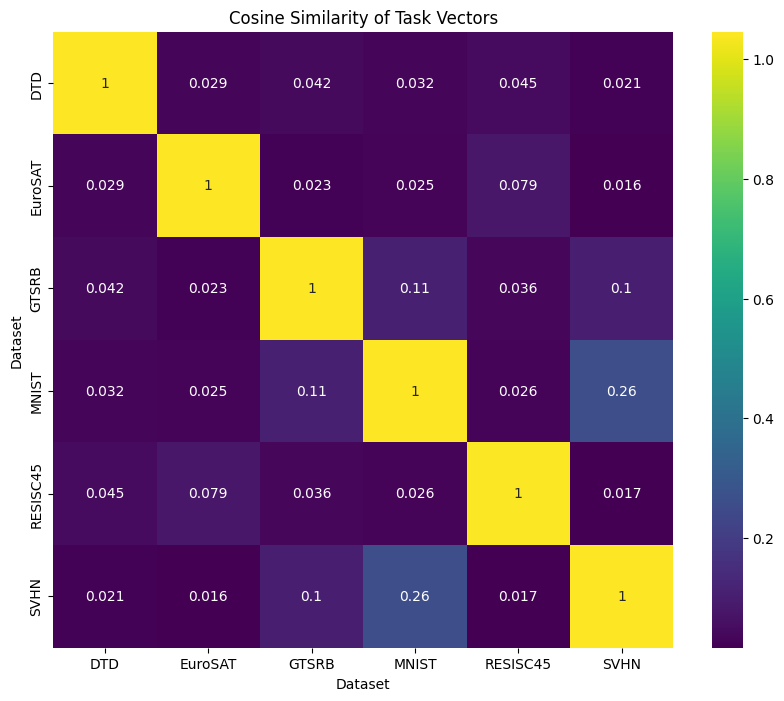

In [ ]:
# Set the hyperparameters needed to the values decided above
dataset_name = dataset_name_original
model_version = model_version_original

# Initialise task vectors
task_vectors = {}
# Store the task vector for every dataset in a task_vectors
for dataset_name in datasets_name:
  task_vectors[dataset_name] = compute_task_vector(dataset_name, models_location, model_version)

# Convert task vectors to numpy arrays for cosine similarity calculation
task_vectors_np = {k: normalize_vector(torch.cat([v[key].flatten() for key in v]).cpu().numpy()) for k, v in task_vectors.items()}

# Compute cosine similarity matrix
cosine_sim_matrix = cosine_similarity(list(task_vectors_np.values()))

# Create confusion matrix
confusion_matrix = np.zeros((len(datasets_name), len(datasets_name)))

# Calculate the confusion matrix entry by entry
for i, dataset_name1 in enumerate(datasets_name):
  for j, dataset_name2 in enumerate(datasets_name):
    confusion_matrix[i, j] = cosine_sim_matrix[i, j]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=datasets_name, yticklabels=datasets_name, annot=True, cmap="viridis")
plt.title("Cosine Similarity of Task Vectors")
plt.xlabel("Dataset")
plt.ylabel("Dataset")
plt.show()

### Confusion Matrix Between Mulitask Vector and Task Vectors

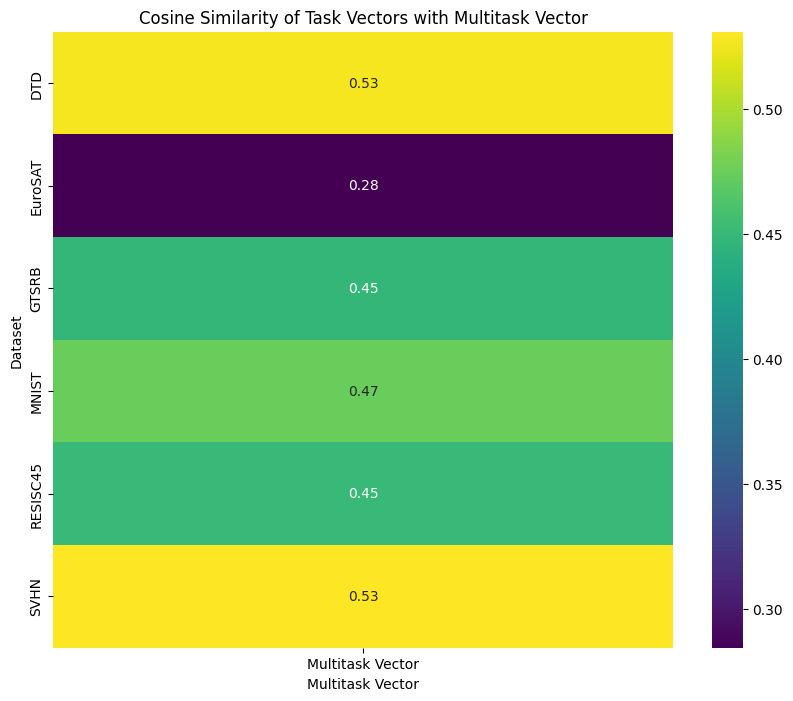

In [ ]:
# Initialize an empty multitask vector
multitask_vector = None

# Sum the task vectors for each dataset_name
for dataset_name in datasets_name:
  if multitask_vector is None:
    multitask_vector = copy.deepcopy(task_vectors[dataset_name])
  else:
    for key in task_vectors[dataset_name]:
      if key in multitask_vector:
        multitask_vector[key] += task_vectors[dataset_name][key]
      else:
        multitask_vector[key] = task_vectors[dataset_name][key]

# Normalize task vectors
task_vectors_np = {k: normalize_vector(torch.cat([v[key].flatten() for key in v]).cpu().numpy()) for k, v in task_vectors.items()}

# Normalize multitask vector
multitask_vector_np = normalize_vector(torch.cat([multitask_vector[key].flatten() for key in multitask_vector]).cpu().numpy())

# initialise confusion matrix
confusion_matrix = np.zeros((len(task_vectors), 1))

# Create confusion matrix
for i, dataset_name in enumerate(task_vectors):
    confusion_matrix[i, 0] = cosine_similarity([task_vectors_np[dataset_name]], [multitask_vector_np])[0, 0]

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, xticklabels=["Multitask Vector"], yticklabels=list(task_vectors.keys()), annot=True, cmap="viridis")
plt.title("Cosine Similarity of Task Vectors with Multitask Vector")
plt.xlabel("Multitask Vector")
plt.ylabel("Dataset")
plt.show()

# Clear GPU vRam
torch.cuda.empty_cache()

## 04 - Alpha Optimisation

In this section, the multitask vector is defined for each model version, it is added to the pretrained model's state dictionary and the value of alpha with the best performance on the validation will be used to create the multitask model.

### Extract the multitask task vector a sum of task vectors  

In [ ]:
# model_version = model_version_original
model_version = "V13"
batch_size = batch_size_original
num_workers = num_workers_original

pt_path = f"{models_location}/encoder_PreTrained.pt"

# Create the task vector for the model specified in "model_version" and store them in "task_vectors"
task_vectors = {}
for dataset_name in datasets_name:
  # print(dataset_name)
  ft_path = f"{models_location}/{model_version}_encoder_SingleTask_{dataset_name}.pt"
  task_vector = NonLinearTaskVector(pt_path, ft_path)
  task_vectors[dataset_name] = task_vector.vector

# Initialize an empty multitask vector
multitask_vector = None

# Sum the task vectors for each dataset_name
for dataset_name in datasets_name:
  if multitask_vector is None:
    multitask_vector = copy.deepcopy(task_vectors[dataset_name])
  else:
    for key in task_vectors[dataset_name]:
      if key in multitask_vector:
        multitask_vector[key] += task_vectors[dataset_name][key]
      else:
        multitask_vector[key] = task_vectors[dataset_name][key]

### Test the multitask models obtained sweeping alpha and save the results for each dataset

In [ ]:
# Define the vector of the values of alpha to test
alpha_vec = np.arange(0, 1.05, .05)

# Instantiate a dataframe where to save the result of the multitask model for each value of alpha and dataset tested
results_alpha_optim = pd.DataFrame(np.nan, index=range(len(alpha_vec)), columns=[["Alpha"] + datasets_name])
results_alpha_optim['Alpha'] = alpha_vec

# Iterate through the values of alpha
for idx_alpha, alpha in tqdm(enumerate(alpha_vec), total=len(alpha_vec), desc="\n\nIterating alpha"):
  print("\n\n")

  # Load the state dictionary of the pretrained model stored in the "pt_path" folder
  pt_path = f"{models_location}/encoder_PreTrained.pt"
  state_dict = torch.load(pt_path)

  # Add the scaled multitask vector to the pretrained model to create the state dictionary of the multitask model
  for key in state_dict:
    state_dict[key] = state_dict[key].to(device) + alpha*multitask_vector[key].to(device)

  # Iterate through the datasets
  for idx_dataset, dataset_name in tqdm(enumerate(datasets_name), total=len(datasets_name), desc="Iterating dataset"):
    print("\n")

    # Create the multitask model
    model = create_model(state_dict=state_dict)
    # Test it in the dataset chosen for the current iteration
    acc = model_performance(model, dataset_name, show_tqdm=False)
    # Take the validation accuracy form the result
    acc = acc['Validation Accuracy [%]']
    # Display the results
    print(f"\nMultitask model accuracy (in {dataset_name} with alpha = {alpha}) = {acc} %")
    # Add the results to the dataframe
    results_alpha_optim.loc[idx_alpha, dataset_name] = acc

# Print the dataframe at the end of the process
results_alpha_optim

# Clear GPU vRam
torch.cuda.empty_cache()



Iterating alpha:   0%|                                                                        | 0/11 [00:00<?, ?it/s]


Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.41s/it]


Multitask model accuracy (in DTD with alpha = 0.0) = 42.15277777777778 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:23,  6.00s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.0) = 40.318627450980394 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.56s/it]


Multitask model accuracy (in GTSRB with alpha = 0.0) = 27.752976190476193 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.80s/it]


Multitask model accuracy (in MNIST with alpha = 0.0) = 52.26910828025477 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.58s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.0) = 57.65625 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.28s/it]


Iterating alpha:   9%|█████▊                                                          | 1/11 [00:49<08:19, 49.94s/it]


Multitask model accuracy (in SVHN with alpha = 0.0) = 25.975318471337577 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.56s/it]


Multitask model accuracy (in DTD with alpha = 0.1) = 42.11805555555556 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.21s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.1) = 50.25735294117647 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.61s/it]


Multitask model accuracy (in GTSRB with alpha = 0.1) = 35.86309523809524 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.84s/it]


Multitask model accuracy (in MNIST with alpha = 0.1) = 62.24124203821656 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.59s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.1) = 64.375 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.39s/it]


Iterating alpha:  18%|███████████▋                                                    | 2/11 [01:40<07:32, 50.29s/it]


Multitask model accuracy (in SVHN with alpha = 0.1) = 50.15923566878981 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.60s/it]


Multitask model accuracy (in DTD with alpha = 0.2) = 39.44444444444444 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.19s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.2) = 47.818627450980394 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:19<00:19,  6.66s/it]


Multitask model accuracy (in GTSRB with alpha = 0.2) = 43.973214285714285 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.87s/it]


Multitask model accuracy (in MNIST with alpha = 0.2) = 72.45222929936305 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.58s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.2) = 67.65625 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.35s/it]


Iterating alpha:  27%|█████████████████▍                                              | 3/11 [02:30<06:42, 50.28s/it]


Multitask model accuracy (in SVHN with alpha = 0.2) = 62.181528662420384 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.45s/it]


Multitask model accuracy (in DTD with alpha = 0.30000000000000004) = 36.11111111111111 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.02s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.30000000000000004) = 34.73039215686274 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.51s/it]


Multitask model accuracy (in GTSRB with alpha = 0.30000000000000004) = 47.28422619047619 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.77s/it]


Multitask model accuracy (in MNIST with alpha = 0.30000000000000004) = 80.29458598726114 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.50s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.30000000000000004) = 62.708333333333336 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.26s/it]


Iterating alpha:  36%|███████████████████████▎                                        | 4/11 [03:20<05:50, 50.06s/it]


Multitask model accuracy (in SVHN with alpha = 0.30000000000000004) = 69.38694267515923 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.49s/it]


Multitask model accuracy (in DTD with alpha = 0.4) = 29.201388888888886 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.12s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.4) = 28.54166666666667 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.61s/it]


Multitask model accuracy (in GTSRB with alpha = 0.4) = 41.294642857142854 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.86s/it]


Multitask model accuracy (in MNIST with alpha = 0.4) = 82.34474522292994 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:36<00:07,  7.69s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.4) = 53.645833333333336 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.36s/it]


Iterating alpha:  45%|█████████████████████████████                                   | 5/11 [04:10<05:00, 50.16s/it]


Multitask model accuracy (in SVHN with alpha = 0.4) = 71.4171974522293 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.53s/it]


Multitask model accuracy (in DTD with alpha = 0.5) = 21.145833333333332 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.06s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.5) = 18.639705882352942 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.53s/it]


Multitask model accuracy (in GTSRB with alpha = 0.5) = 29.985119047619047 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.76s/it]


Multitask model accuracy (in MNIST with alpha = 0.5) = 74.60191082802548 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.53s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.5) = 32.395833333333336 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.28s/it]


Iterating alpha:  55%|██████████████████████████████████▉                             | 6/11 [05:00<04:10, 50.07s/it]


Multitask model accuracy (in SVHN with alpha = 0.5) = 63.8734076433121 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.56s/it]


Multitask model accuracy (in DTD with alpha = 0.6000000000000001) = 12.36111111111111 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.16s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.6000000000000001) = 19.42401960784314 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.58s/it]


Multitask model accuracy (in GTSRB with alpha = 0.6000000000000001) = 18.489583333333336 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.82s/it]


Multitask model accuracy (in MNIST with alpha = 0.6000000000000001) = 59.275477707006374 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.61s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.6000000000000001) = 13.802083333333334 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.31s/it]


Iterating alpha:  64%|████████████████████████████████████████▋                       | 7/11 [05:50<03:20, 50.07s/it]


Multitask model accuracy (in SVHN with alpha = 0.6000000000000001) = 51.074840764331206 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.51s/it]


Multitask model accuracy (in DTD with alpha = 0.7000000000000001) = 6.805555555555556 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.07s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.7000000000000001) = 9.65686274509804 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.59s/it]


Multitask model accuracy (in GTSRB with alpha = 0.7000000000000001) = 9.412202380952381 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.83s/it]


Multitask model accuracy (in MNIST with alpha = 0.7000000000000001) = 45.999203821656046 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.56s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.7000000000000001) = 5.572916666666667 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.31s/it]


Iterating alpha:  73%|██████████████████████████████████████████████▌                 | 8/11 [06:40<02:30, 50.08s/it]


Multitask model accuracy (in SVHN with alpha = 0.7000000000000001) = 38.43550955414013 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:22,  4.46s/it]


Multitask model accuracy (in DTD with alpha = 0.8) = 3.923611111111111 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.13s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.8) = 13.051470588235295 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.57s/it]


Multitask model accuracy (in GTSRB with alpha = 0.8) = 6.138392857142857 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.80s/it]


Multitask model accuracy (in MNIST with alpha = 0.8) = 42.05812101910828 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.59s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.8) = 3.28125 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.32s/it]


Iterating alpha:  82%|████████████████████████████████████████████████████▎           | 9/11 [07:30<01:40, 50.08s/it]


Multitask model accuracy (in SVHN with alpha = 0.8) = 27.647292993630572 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:23,  4.63s/it]


Multitask model accuracy (in DTD with alpha = 0.9) = 3.125 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.12s/it]


Multitask model accuracy (in EuroSAT with alpha = 0.9) = 13.223039215686274 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:19<00:19,  6.65s/it]


Multitask model accuracy (in GTSRB with alpha = 0.9) = 4.352678571428571 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:29<00:15,  7.95s/it]


Multitask model accuracy (in MNIST with alpha = 0.9) = 39.90843949044586 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:36<00:07,  7.62s/it]


Multitask model accuracy (in RESISC45 with alpha = 0.9) = 2.7604166666666665 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:50<00:00,  8.34s/it]


Iterating alpha:  91%|█████████████████████████████████████████████████████████▎     | 10/11 [08:21<00:50, 50.13s/it]


Multitask model accuracy (in SVHN with alpha = 0.9) = 23.148885350318473 %






Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:04<00:23,  4.63s/it]


Multitask model accuracy (in DTD with alpha = 1.0) = 2.7083333333333335 %


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [00:11<00:24,  6.10s/it]


Multitask model accuracy (in EuroSAT with alpha = 1.0) = 14.705882352941178 %


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [00:18<00:19,  6.55s/it]


Multitask model accuracy (in GTSRB with alpha = 1.0) = 4.6875 %


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  67%|███████████████████████████████████████████▎                     | 4/6 [00:28<00:15,  7.88s/it]


Multitask model accuracy (in MNIST with alpha = 1.0) = 41.93869426751593 %


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.



Iterating dataset:  83%|██████████████████████████████████████████████████████▏          | 5/6 [00:35<00:07,  7.57s/it]


Multitask model accuracy (in RESISC45 with alpha = 1.0) = 3.3854166666666665 %


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat



Iterating dataset: 100%|█████████████████████████████████████████████████████████████████| 6/6 [00:49<00:00,  8.31s/it]


Iterating alpha: 100%|███████████████████████████████████████████████████████████████| 11/11 [09:11<00:00, 50.10s/it]

Iterating alpha: 100%|███████████████████████████████████████████████████████████████| 11/11 [09:11<00:00, 50.11s/it]


Multitask model accuracy (in SVHN with alpha = 1.0) = 20.621019108280255 %


### Save the Results

In [ ]:
# Create the folder where to save the results if not present
if not os.path.exists(f"{results_location}//Alpha Optim"):
  os.mkdir(f"{results_location}//Alpha Optim")
  print(f"'{results_location}/Alpha Optim' has been correctly created")

result_location_and_name = f"{results_location}//Alpha Optim//results_alpha_optim_{model_version}.txt"
# Save results to a text file in tabular format
with open(result_location_and_name, "w") as file:
    # Write the header
    headers = "\t".join(str(key) for key in results_alpha_optim.keys())
    file.write(headers + "\n")

    # Write the rows
    for i in range(len(results_alpha_optim['Alpha'])):
        row = "\t".join(str(results_alpha_optim[key][i]) for key in results_alpha_optim)
        file.write(row + "\n")

print(f"Results successfully saved {result_location_and_name} in tabular format!")

Results successfully saved results//Alpha Optim//results_alpha_optim_V13.txt in tabular format!


## 05 - Multitask and Scaled Singletask Model Testing



### Test The Multitask Model and Save Partial Results

In [ ]:
batch_size = batch_size_original
num_workers = num_workers_original

model_versions = ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13"]
alpha_vec = [.3, .25, .3, .2, .3, .25, .3, .35, .15, .3, .3, .3, .2]
pt_path = f"{models_location}/encoder_PreTrained.pt"

for model_idx, model_version in tqdm(enumerate(model_versions), total=len(model_versions), desc="Iterating Model Version"):
  alpha = alpha_vec[model_idx]
  print(f"\nTesting Multitask model: {model_version} \nAlpha = {alpha}\n")

  task_vectors = {}
  for dataset_name in datasets_name:
    # print(dataset_name)
    ft_path = f"{models_location}/{model_version}_encoder_SingleTask_{dataset_name}.pt"
    task_vector = NonLinearTaskVector(pt_path, ft_path)
    task_vectors[dataset_name] = task_vector.vector

  # Initialize an empty multitask vector
  multitask_vector = None

  # Sum the task vectors for each dataset_name
  for dataset_name in datasets_name:
    if multitask_vector is None:
      multitask_vector = copy.deepcopy(task_vectors[dataset_name])
    else:
      for key in task_vectors[dataset_name]:
        if key in multitask_vector:
          multitask_vector[key] += task_vectors[dataset_name][key]
        else:
          multitask_vector[key] = task_vectors[dataset_name][key]

  state_dict = torch.load(pt_path)

  for key in state_dict:
    state_dict[key] = state_dict[key].to(device) + alpha*multitask_vector[key].to(device)

  for idx_dataset, dataset_name in tqdm(enumerate(datasets_name), total=len(datasets_name), desc="Iterating dataset"):
    print("\n")
    save_path = f"{results_location}/Final Results/Multitask/{model_version}_{dataset_name}.txt"
    if os.path.exists(save_path):
      print(f"Test not run, because '{save_path}' already exists.")
    else:
      model = create_model(state_dict=state_dict)# Define where to save the results
      # Calculate the test accuracy, train accuracy and the fisher matrix trace logaritm and save them in the location specified in "save_path"
      model_performance(model, dataset_name, addValidation=False, addTest=True, addTrain=True, addFisher=True, save_results=save_path, show_tqdm=False)

  # Clean the variables using the VRAM that otherwise would get saturated
  torch.cuda.empty_cache()

Iterating Model Version:   0%|                                                                  | 0/13 [00:00<?, ?it/s]


Testing Multitask model: V1 
Alpha = 0.3




Iterating Model Version:   8%|████▍                                                     | 1/13 [00:02<00:29,  2.47s/it]



Test not run, because 'results/Final Results/Multitask/V1_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V1_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V1_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V1_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V1_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V1_SVHN.txt' already exists.

Testing Multitask model: V2 
Alpha = 0.25




Iterating Model Version:  15%|████████▉                                                 | 2/13 [00:05<00:29,  2.68s/it]



Test not run, because 'results/Final Results/Multitask/V2_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V2_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V2_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V2_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V2_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V2_SVHN.txt' already exists.

Testing Multitask model: V3 
Alpha = 0.3




Iterating Model Version:  23%|█████████████▍                                            | 3/13 [00:08<00:28,  2.84s/it]



Test not run, because 'results/Final Results/Multitask/V3_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V3_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V3_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V3_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V3_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V3_SVHN.txt' already exists.

Testing Multitask model: V4 
Alpha = 0.2




Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:56<04:44, 56.95s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_DTD.txt'


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [02:20<04:50, 72.50s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_EuroSAT.txt'


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  50%|████████████████████████████████                                | 3/6 [07:00<08:21, 167.13s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_GTSRB.txt'


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  67%|██████████████████████████████████████████▋                     | 4/6 [09:36<05:25, 162.79s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_MNIST.txt'


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  83%|█████████████████████████████████████████████████████▎          | 5/6 [11:23<02:22, 142.92s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_RESISC45.txt'


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat

Fisher matrix logarithm trace Calcuation ...
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating Model Version:  31%|█████████████████▌                                       | 4/13 [15:12<53:46, 358.49s/it]


Results correctly saved in 'results/Final Results/Multitask/V4_SVHN.txt'

Testing Multitask model: V5 
Alpha = 0.3




Iterating Model Version:  38%|█████████████████████▉                                   | 5/13 [15:14<30:42, 230.29s/it]



Test not run, because 'results/Final Results/Multitask/V5_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V5_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V5_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V5_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V5_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V5_SVHN.txt' already exists.

Testing Multitask model: V6 
Alpha = 0.25




Iterating Model Version:  46%|██████████████████████████▎                              | 6/13 [15:17<17:50, 152.98s/it]



Test not run, because 'results/Final Results/Multitask/V6_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V6_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V6_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V6_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V6_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V6_SVHN.txt' already exists.

Testing Multitask model: V7 
Alpha = 0.3




Iterating Model Version:  54%|██████████████████████████████▋                          | 7/13 [15:20<10:23, 103.91s/it]



Test not run, because 'results/Final Results/Multitask/V7_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V7_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V7_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V7_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V7_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V7_SVHN.txt' already exists.

Testing Multitask model: V8 
Alpha = 0.35




Iterating Model Version:  62%|███████████████████████████████████▋                      | 8/13 [15:23<05:58, 71.79s/it]



Test not run, because 'results/Final Results/Multitask/V8_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V8_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V8_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V8_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V8_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V8_SVHN.txt' already exists.

Testing Multitask model: V9 
Alpha = 0.15




Iterating Model Version:  69%|████████████████████████████████████████▏                 | 9/13 [15:26<03:21, 50.29s/it]



Test not run, because 'results/Final Results/Multitask/V9_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V9_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V9_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V9_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V9_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V9_SVHN.txt' already exists.

Testing Multitask model: V10 
Alpha = 0.3




Iterating Model Version:  77%|███████████████████████████████████████████▊             | 10/13 [15:29<01:47, 35.67s/it]



Test not run, because 'results/Final Results/Multitask/V10_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V10_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V10_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V10_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V10_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V10_SVHN.txt' already exists.

Testing Multitask model: V11 
Alpha = 0.3




Iterating Model Version:  85%|████████████████████████████████████████████████▏        | 11/13 [15:32<00:51, 25.62s/it]



Test not run, because 'results/Final Results/Multitask/V11_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V11_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V11_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V11_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V11_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V11_SVHN.txt' already exists.

Testing Multitask model: V12 
Alpha = 0.3




Iterating Model Version:  92%|████████████████████████████████████████████████████▌    | 12/13 [15:35<00:18, 18.68s/it]



Test not run, because 'results/Final Results/Multitask/V12_DTD.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V12_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V12_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V12_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V12_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Multitask/V12_SVHN.txt' already exists.

Testing Multitask model: V13 
Alpha = 0.2




Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:56<04:42, 56.56s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_DTD.txt'


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [02:10<04:27, 66.82s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_EuroSAT.txt'


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  50%|████████████████████████████████                                | 3/6 [07:11<08:41, 173.86s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_GTSRB.txt'


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  67%|██████████████████████████████████████████▋                     | 4/6 [09:29<05:19, 159.68s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_MNIST.txt'


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  83%|█████████████████████████████████████████████████████▎          | 5/6 [11:01<02:15, 135.13s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_RESISC45.txt'


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat

Fisher matrix logarithm trace Calcuation ...
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating Model Version: 100%|████████████████████████████████████████████████████████| 13/13 [30:01<00:00, 138.58s/it]


Results correctly saved in 'results/Final Results/Multitask/V13_SVHN.txt'


### Save the Complete Results of the Multitask Model

### Save the Results of Multitask Model Results in Tabular Form

This code has been generated by copilot (you can notice form the indentation), I will not further elaborate.

In [ ]:
# Define the directory containing the files
directory = os.path.join(results_location, "Final Results", "Multitask")

data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        # Extract version and dataset from the filename
        parts = filename.split('_')
        version = parts[0]
        dataset = parts[1].split('.')[0]

        # Read the file content
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Split the line into metric and value
                metric, value = line.strip().split(': ')
                data.append([version, metric, dataset, float(value)])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Model Version', 'Metric', 'Dataset', 'Value'])

# Pivot the DataFrame to get the desired table format
table = df.pivot_table(index=['Model Version', 'Metric'], columns='Dataset', values='Value', aggfunc='first').reset_index()

# Ensure each element is placed in its own cell
table.columns.name = None

# # Save the table to a CSV file
# save_final = f"{directory}/Final_results_table.csv"
# table.to_csv(save_final, index=False)

# print(f"Table saved to '{save_final}'")

result_location_and_name = f"{directory}/Final_results_table.txt"
# Save results to a text file in tabular format
with open(result_location_and_name, "w") as file:
    # Write the header
    headers = "\t".join(str(key) for key in table.keys())
    file.write(headers + "\n")

    # Write the rows
    for i in range(len(table["Model Version"])):
        row = "\t".join(str(table[key][i]) for key in table)
        file.write(row + "\n")

print(f"Results successfully saved {result_location_and_name} in tabular format!")

Results successfully saved results\Final Results\Multitask/Final_results_table.txt in tabular format!


### Test the Scaled Singletask Model and Save Results

In [ ]:
# Set hyperparameters to the values decided by the user
batch_size = batch_size_original
num_workers = num_workers_original

# Define the dataset to iterate and for how many epochs they have been iterated during training
model_versions = ["V1", "V2", "V3", "V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11", "V12", "V13"]
alpha_vec = [.3, .25, .3, .2, .3, .25, .3, .35, .15, .3, .3, .3, .2]

# Define the path where the pretrained model state dictionary has been saved
pt_path = f"{models_location}/encoder_PreTrained.pt"

# Iterate through the model versions
for model_idx, model_version in tqdm(enumerate(model_versions), total=len(model_versions), desc="Iterating Model Version"):
  alpha = alpha_vec[model_idx]
  print(f"\nTesting Scaled Singletask model: {model_version} \nAlpha = {alpha}\n")

  # Iterate thourgh the datasets
  for idx_dataset, dataset_name in tqdm(enumerate(datasets_name), total=len(datasets_name), desc="Iterating dataset"):
    print("\n")

    # Define where to save the results and the name of the result file
    save_path = f"{results_location}/Final Results/Singletask Scaled/{model_version}_{dataset_name}.txt"

    # If the result file does alerady exist the testing is not run and a message is displayed instead
    if os.path.exists(save_path):
      print(f"Test not run, because '{save_path}' already exists.")
    else:

      # Load the pretrained model's state dictionary
      state_dict = torch.load(pt_path)

      # Define the finetuned state dictionary to use to create the task vector
      path = f"{models_location}/{model_version}_encoder_SingleTask_{dataset_name}.pt"

      # Create the task vector
      task_vector = NonLinearTaskVector(pt_path, path)

      # Add the scaled task vector to the sta
      for key in state_dict:
        state_dict[key] = state_dict[key].to(device) + alpha*task_vector.vector[key].to(device)

      model = create_model(state_dict=state_dict)# Define where to save the results

      # Calculate the test accuracy, train accuracy and the fisher matrix trace logaritm and save them in the location specified in "save_path"
      model_performance(model, dataset_name, addValidation=False, addTest=True, addTrain=True, addFisher=True, save_results=save_path, show_tqdm=False)


  # Clean the variables using the VRAM that otherwise would get saturated
  torch.cuda.empty_cache()

Iterating Model Version:   0%|                                                                  | 0/13 [00:00<?, ?it/s]


Testing Scaled Singletask model: V1 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5833.52it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V1_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V1_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V1_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V1_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V1_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V1_SVHN.txt' already exists.

Testing Scaled Singletask model: V2 
Alpha = 0.25




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5974.79it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V2_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V2_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V2_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V2_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V2_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V2_SVHN.txt' already exists.

Testing Scaled Singletask model: V3 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5977.63it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V3_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V3_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V3_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V3_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V3_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V3_SVHN.txt' already exists.

Testing Scaled Singletask model: V4 
Alpha = 0.2




Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  17%|██████████▊                                                      | 1/6 [01:00<05:04, 60.99s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_DTD.txt'


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [02:19<04:44, 71.12s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_EuroSAT.txt'


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  50%|████████████████████████████████                                | 3/6 [05:07<05:46, 115.64s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_GTSRB.txt'


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  67%|██████████████████████████████████████████▋                     | 4/6 [07:53<04:30, 135.41s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_MNIST.txt'


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  83%|█████████████████████████████████████████████████████▎          | 5/6 [09:26<02:00, 120.05s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_RESISC45.txt'


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat

Fisher matrix logarithm trace Calcuation ...
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating Model Version:  31%|█████████████████▌                                       | 4/13 [12:46<28:44, 191.63s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V4_SVHN.txt'

Testing Scaled Singletask model: V5 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5969.12it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V5_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V5_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V5_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V5_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V5_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V5_SVHN.txt' already exists.

Testing Scaled Singletask model: V6 
Alpha = 0.25




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5976.21it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V6_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V6_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V6_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V6_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V6_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V6_SVHN.txt' already exists.

Testing Scaled Singletask model: V7 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5966.29it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V7_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V7_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V7_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V7_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V7_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V7_SVHN.txt' already exists.

Testing Scaled Singletask model: V8 
Alpha = 0.35




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 3988.24it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V8_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V8_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V8_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V8_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V8_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V8_SVHN.txt' already exists.

Testing Scaled Singletask model: V9 
Alpha = 0.15




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5981.89it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V9_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V9_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V9_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V9_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V9_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V9_SVHN.txt' already exists.

Testing Scaled Singletask model: V10 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5919.98it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V10_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V10_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V10_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V10_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V10_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V10_SVHN.txt' already exists.

Testing Scaled Singletask model: V11 
Alpha = 0.3




Iterating dataset: 100%|███████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 5973.37it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V11_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V11_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V11_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V11_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V11_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V11_SVHN.txt' already exists.

Testing Scaled Singletask model: V12 
Alpha = 0.3




Iterating dataset: 100%|█████████████████████████████████████████████████████████████████████████| 6/6 [00:00<?, ?it/s]




Test not run, because 'results/Final Results/Singletask Scaled/V12_DTD.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V12_EuroSAT.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V12_GTSRB.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V12_MNIST.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V12_RESISC45.txt' already exists.


Test not run, because 'results/Final Results/Singletask Scaled/V12_SVHN.txt' already exists.

Testing Scaled Singletask model: V13 
Alpha = 0.2




Iterating dataset:   0%|                                                                         | 0/6 [00:00<?, ?it/s]



Classification head for ViT-B-32 on DTDVal exists at models\head_DTDVal.pt
Loading classification head from models\head_DTDVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  17%|██████████▊                                                      | 1/6 [00:52<04:24, 52.85s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_DTD.txt'


Classification head for ViT-B-32 on EuroSATVal exists at models\head_EuroSATVal.pt
Loading classification head from models\head_EuroSATVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  33%|█████████████████████▋                                           | 2/6 [02:08<04:25, 66.49s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_EuroSAT.txt'


Classification head for ViT-B-32 on GTSRBVal exists at models\head_GTSRBVal.pt
Loading classification head from models\head_GTSRBVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  50%|████████████████████████████████▌                                | 3/6 [03:54<04:13, 84.49s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_GTSRB.txt'


Classification head for ViT-B-32 on MNISTVal exists at models\head_MNISTVal.pt
Loading classification head from models\head_MNISTVal.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  67%|██████████████████████████████████████████▋                     | 4/6 [06:49<03:59, 119.93s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_MNIST.txt'


Classification head for ViT-B-32 on RESISC45Val exists at models\head_RESISC45Val.pt
Loading classification head from models\head_RESISC45Val.pt
Loading ViT-B-32 pre-trained weights.

Fisher matrix logarithm trace Calcuation ...


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating dataset:  83%|█████████████████████████████████████████████████████▎          | 5/6 [08:33<01:54, 114.35s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_RESISC45.txt'


Classification head for ViT-B-32 on SVHNVal exists at models\head_SVHNVal.pt
Loading classification head from models\head_SVHNVal.pt
Loading ViT-B-32 pre-trained weights.
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat

Fisher matrix logarithm trace Calcuation ...
Using downloaded and verified file: data\svhn\train_32x32.mat
Using downloaded and verified file: data\svhn\test_32x32.mat


  0%|          | 0/200 [00:00<?, ?it/s]


Iterating Model Version: 100%|████████████████████████████████████████████████████████| 13/13 [26:20<00:00, 121.61s/it]


Results correctly saved in 'results/Final Results/Singletask Scaled/V13_SVHN.txt'


### Save the Results of the Scaled Singletask Model Results in Tabular Form

This code has been generated by copilot (you can notice form the indentation), I will not further elaborate.

In [ ]:
# Define the directory containing the files
directory = os.path.join(results_location, "Final Results", "Singletask Scaled")

data = []

# Loop through each file in the directory
for filename in os.listdir(directory):
    if filename.endswith('.txt'):
        # Extract version and dataset from the filename
        parts = filename.split('_')
        version = parts[0]
        dataset = parts[1].split('.')[0]

        # Read the file content
        with open(os.path.join(directory, filename), 'r') as file:
            lines = file.readlines()
            for line in lines:
                # Split the line into metric and value
                metric, value = line.strip().split(': ')
                data.append([version, metric, dataset, float(value)])

# Create a DataFrame from the data
df = pd.DataFrame(data, columns=['Model Version', 'Metric', 'Dataset', 'Value'])

# Pivot the DataFrame to get the desired table format
table = df.pivot_table(index=['Model Version', 'Metric'], columns='Dataset', values='Value', aggfunc='first').reset_index()

# Ensure each element is placed in its own cell
table.columns.name = None

# # Save the table to a CSV file
# save_final = f"{directory}/Final_results_table.csv"
# table.to_csv(save_final, index=False)

# print(f"Table saved to '{save_final}'")

result_location_and_name = f"{directory}/Final_results_table.txt"
# Save results to a text file in tabular format
with open(result_location_and_name, "w") as file:
    # Write the header
    headers = "\t".join(str(key) for key in table.keys())
    file.write(headers + "\n")

    # Write the rows
    for i in range(len(table["Model Version"])):
        row = "\t".join(str(table[key][i]) for key in table)
        file.write(row + "\n")

print(f"Results successfully saved {result_location_and_name} in tabular format!")

Results successfully saved results\Final Results\Singletask Scaled/Final_results_table.txt in tabular format!
